In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

In [2]:
df = pd.read_csv('data_test')
df = df.drop(columns=df.columns[0])

In [3]:
df.head(5)

,X1,X2,Sin,pdiv,Y1,Y2
0,0.457633,0.274310,0.668316,0.348848,0,1
1,0.170258,0.905733,0.880061,0.536556,1,0
2,0.426743,0.067306,0.474195,0.196196,0,1
3,0.033611,0.259964,0.289376,0.079348,0,0
4,0.726409,0.747385,0.995299,0.684748,1,1


# 1. Modelo 1

In [4]:
df_t = torch.Tensor(df[['X1', 'X2']].values)
y1 = torch.Tensor(df[['Y1']].values)
y2 = torch.Tensor(df[['Y2']].values)

In [5]:
model1 = torch.nn.Sequential(
    torch.nn.Linear(2,4),
    torch.nn.ReLU(),
    torch.nn.Linear(4,1),
    torch.nn.Sigmoid()
)

criterion1 = torch.nn.MSELoss()

optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.5)

In [6]:
epochs = 10**5
tau = 1
log_each = 1000
l = []
model1.train()

for e in range(1, epochs + 1):
    y_pred_0 = model1(df_t)
    y_pred_1 = 1 - model1(df_t)

    y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)

    y_pred = F.gumbel_softmax(y_pred.log(), tau=tau, hard=True)

    loss = criterion1(y_pred[:, 0].reshape(1000, 1), y2)
    l.append(loss.item())

    optimizer1.zero_grad()

    loss.backward()

    optimizer1.step()

    if not e % log_each:
        lr = 0.5 - (0.4*e/epochs)
        tau = 1 - (0.3*e/epochs)
        print(f'Epoch {e}/{epochs} Loss {np.mean(l):.5f} Tau {tau} Learn Rate {lr}')
        optimizer1 = torch.optim.SGD(model1.parameters(), lr=lr)

Epoch 1000/100000 Loss 0.44859 Tau 0.997 Learn Rate 0.496
Epoch 2000/100000 Loss 0.42754 Tau 0.994 Learn Rate 0.492
Epoch 3000/100000 Loss 0.42026 Tau 0.991 Learn Rate 0.488
Epoch 4000/100000 Loss 0.41648 Tau 0.988 Learn Rate 0.484
Epoch 5000/100000 Loss 0.41423 Tau 0.985 Learn Rate 0.48
Epoch 6000/100000 Loss 0.41272 Tau 0.982 Learn Rate 0.476
Epoch 7000/100000 Loss 0.41161 Tau 0.979 Learn Rate 0.472
Epoch 8000/100000 Loss 0.41067 Tau 0.976 Learn Rate 0.46799999999999997
Epoch 9000/100000 Loss 0.40992 Tau 0.973 Learn Rate 0.464
Epoch 10000/100000 Loss 0.40924 Tau 0.97 Learn Rate 0.46
Epoch 11000/100000 Loss 0.40871 Tau 0.967 Learn Rate 0.456
Epoch 12000/100000 Loss 0.40829 Tau 0.964 Learn Rate 0.452
Epoch 13000/100000 Loss 0.40788 Tau 0.961 Learn Rate 0.448
Epoch 14000/100000 Loss 0.40759 Tau 0.958 Learn Rate 0.444
Epoch 15000/100000 Loss 0.40728 Tau 0.955 Learn Rate 0.44
Epoch 16000/100000 Loss 0.40704 Tau 0.952 Learn Rate 0.436
Epoch 17000/100000 Loss 0.40686 Tau 0.949 Learn Rate 0.

In [7]:
y_hat1 = model1(df_t).squeeze().detach().numpy()

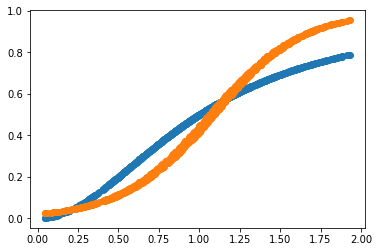

In [8]:
plt.scatter(df.X1.values + df.X2.values, df.pdiv.values)
plt.scatter(df.X1.values + df.X2.values, y_hat1, cmap='red')

# 2. Modelo 2

In [9]:
model2 = torch.nn.Sequential(
    torch.nn.Linear(2,8),
    torch.nn.ReLU(),
    torch.nn.Linear(8,1),
    torch.nn.Sigmoid()
)

criterion2 = torch.nn.MSELoss()

optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.8)

In [10]:
N = 10**2
epochs = 10**4
log_each = 100
l = []
model2.train()

for e in range(1, epochs + 1):

    tau = 1

    y_pred_0 = model2(df_t)
    y_pred_1 = 1 - model2(df_t)

    y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)
    logits = y_pred.log()

    y_pred = F.gumbel_softmax(logits, tau=tau, hard=True)

    for i in range(1, N):
        x = i/N
        tau = 1 + x*(0.3-1)
        y_pred += F.gumbel_softmax(logits=logits, tau=tau, hard=True)

    y_pred = y_pred/N

    loss = criterion2(y_pred[:, 0].reshape(1000, 1), y2)
    l.append(loss.item())

    optimizer2.zero_grad()

    loss.backward()

    optimizer2.step()

    if not e % log_each:
        lr = 0.8 - (0.6*e/epochs)
        print(f'Epoch {e}/{epochs} Loss {np.mean(l):.5f} Learn Rate {lr}')
        optimizer2 = torch.optim.SGD(model2.parameters(), lr=lr)

Epoch 100/10000 Loss 0.23795 Learn Rate 0.794
Epoch 200/10000 Loss 0.22817 Learn Rate 0.788
Epoch 300/10000 Loss 0.22301 Learn Rate 0.782
Epoch 400/10000 Loss 0.22019 Learn Rate 0.776
Epoch 500/10000 Loss 0.21844 Learn Rate 0.77
Epoch 600/10000 Loss 0.21730 Learn Rate 0.764
Epoch 700/10000 Loss 0.21646 Learn Rate 0.758
Epoch 800/10000 Loss 0.21584 Learn Rate 0.752
Epoch 900/10000 Loss 0.21536 Learn Rate 0.746
Epoch 1000/10000 Loss 0.21497 Learn Rate 0.74
Epoch 1100/10000 Loss 0.21465 Learn Rate 0.734
Epoch 1200/10000 Loss 0.21437 Learn Rate 0.7280000000000001
Epoch 1300/10000 Loss 0.21413 Learn Rate 0.7220000000000001
Epoch 1400/10000 Loss 0.21394 Learn Rate 0.7160000000000001
Epoch 1500/10000 Loss 0.21377 Learn Rate 0.7100000000000001
Epoch 1600/10000 Loss 0.21362 Learn Rate 0.7040000000000001
Epoch 1700/10000 Loss 0.21348 Learn Rate 0.6980000000000001
Epoch 1800/10000 Loss 0.21335 Learn Rate 0.6920000000000001
Epoch 1900/10000 Loss 0.21324 Learn Rate 0.686
Epoch 2000/10000 Loss 0.213

In [11]:
y_hat2 = model2(df_t).squeeze().detach().numpy()

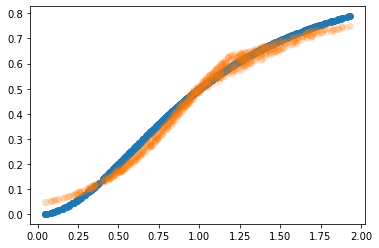

In [14]:
plt.scatter(df.X1.values + df.X2.values, df.pdiv.values)
plt.scatter(df.X1.values + df.X2.values, y_hat2, cmap='red', alpha=0.1)

In [13]:
for a in model2.parameters():
    print(a)

Parameter containing:
tensor([[ 0.5676,  0.1060],
        [-0.1539,  0.4982],
        [-0.9979,  0.4152],
        [-0.1323,  0.9613],
        [-0.4112, -0.4949],
        [ 0.0787,  0.2036],
        [-0.5085, -0.1465],
        [-0.9478, -1.3145]], requires_grad=True)
Parameter containing:
tensor([-0.0521, -0.4373,  0.7387, -0.2503,  0.7687,  0.5343, -0.3646,  1.2219],
       requires_grad=True)
Parameter containing:
tensor([[ 0.2407, -0.3445, -0.8554,  0.7152, -0.9091,  0.3837, -0.1155, -1.9496]],
       requires_grad=True)
Parameter containing:
tensor([0.4105], requires_grad=True)


## Gráfica en 3D

In [18]:
X, Y = np.meshgrid(np.linspace(-5,5,100), np.linspace(-5,5,100))
Z = (X + Y)**2/(1 + (X + Y)**2)

Text(0.5, 0, 'Z')

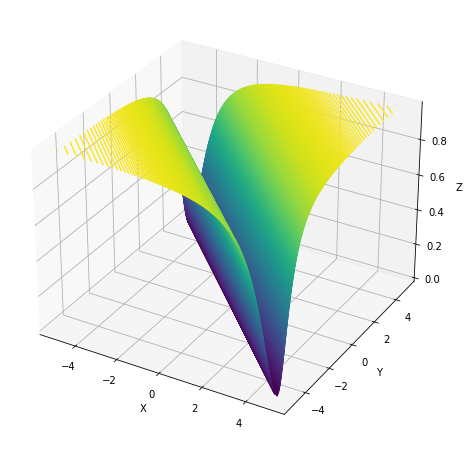

In [19]:
fig = plt.figure(figsize=(20,8))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 1000, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

#fig.savefig('fun_C.eps')

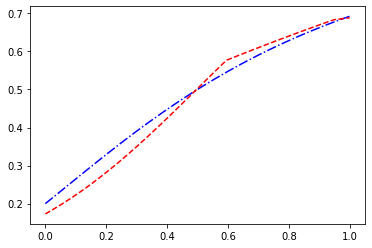

In [63]:
df_aux = pd.DataFrame(columns=['X1', 'X2'])

df_aux['X1'] = np.linspace(0, 1, 100)
df_aux['X2'] = np.full(fill_value=0.5, shape=100, dtype='float64')

y = (df_aux.X1.values + df_aux.X2.values)**2/(1 + (df_aux.X1.values + df_aux.X2.values)**2 )

plt.plot(df_aux.X1.values, y, 'b-.')
plt.plot(df_aux.X1.values, model2(torch.Tensor(df_aux.values)).squeeze().detach().numpy(), 'r--')

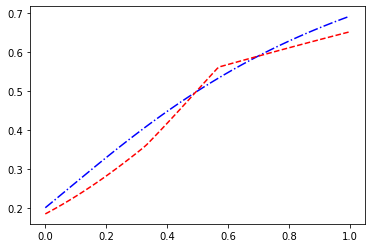

In [62]:
df_aux = pd.DataFrame(columns=['X1', 'X2'])

df_aux['X1'] = np.full(fill_value=0.5, shape=100, dtype='float64')
df_aux['X2'] = np.linspace(0, 1, 100)

y = (df_aux.X1.values + df_aux.X2.values)**2/(1 + (df_aux.X1.values + df_aux.X2.values)**2 )

plt.plot(df_aux.X2.values, y, 'b-.')
plt.plot(df_aux.X2.values, model2(torch.Tensor(df_aux.values)).squeeze().detach().numpy(), 'r--')